In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata

import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid

# from matplotlib.colorbar import ColorbarBase


In [2]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

# load gem
input_file_gem = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gem.nc')
gem = Dataset(input_file_gem, 'r')
gem.variables.keys()

odict_keys(['t', 'SP', 'CT', 'pt', 'SA', 'sigma0', 'gamman'])

### Create Dynamic Height contours with the reference level (1494 dbar) considered as the level of 'no-motion'


In [3]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


## Measurements, GEM field and anomaly for each transect

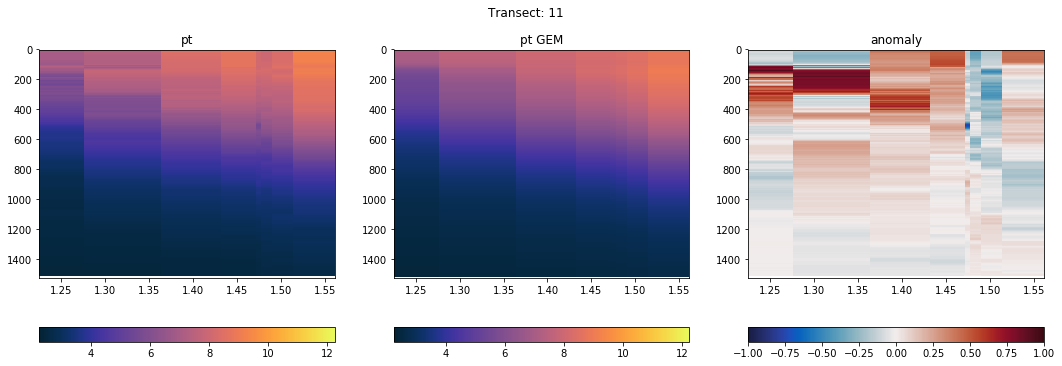

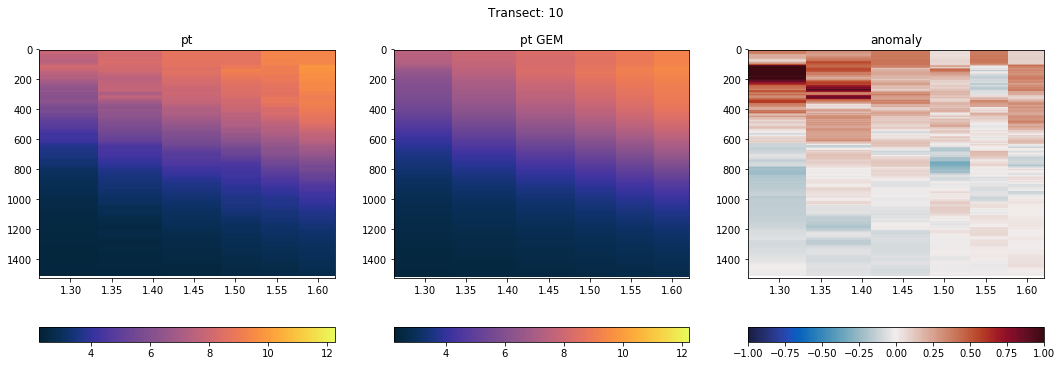

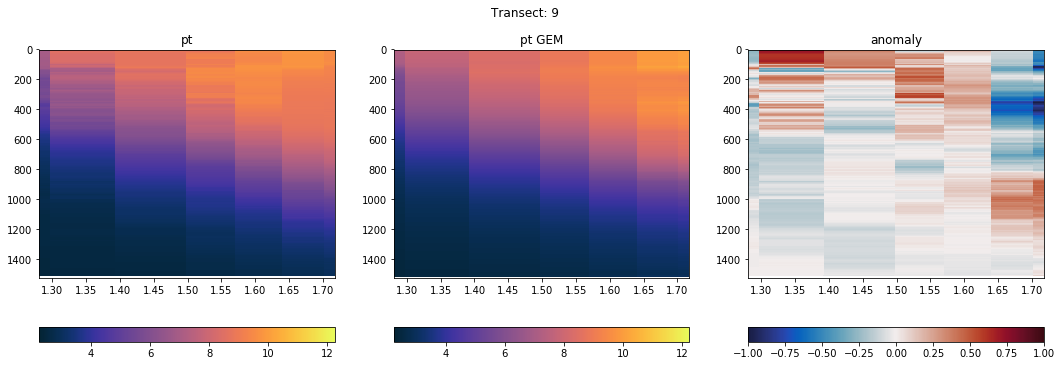

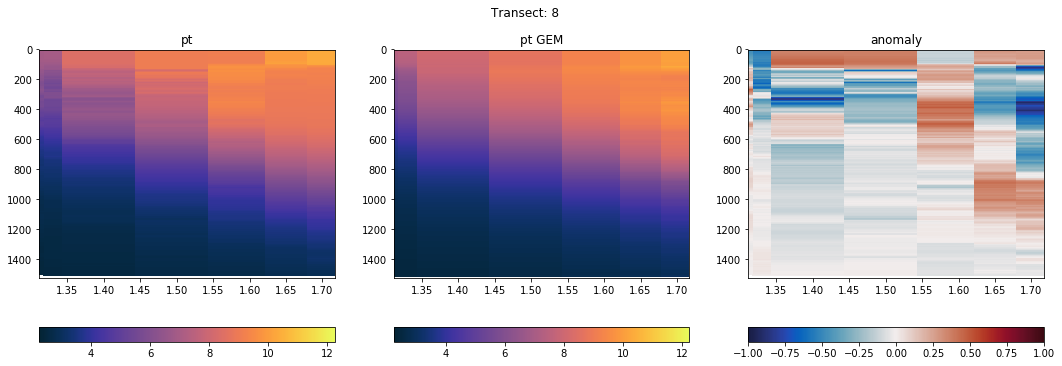

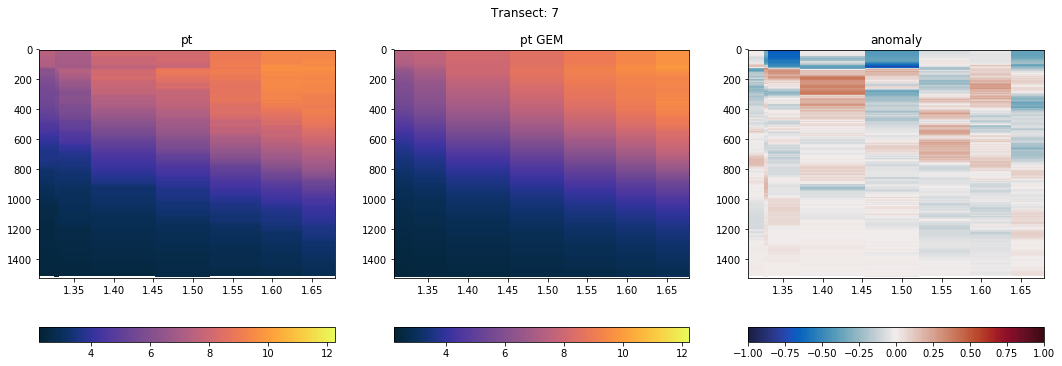

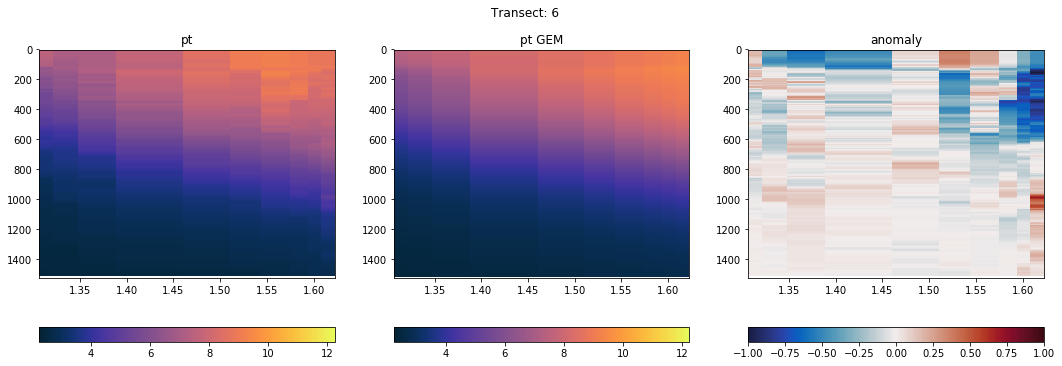

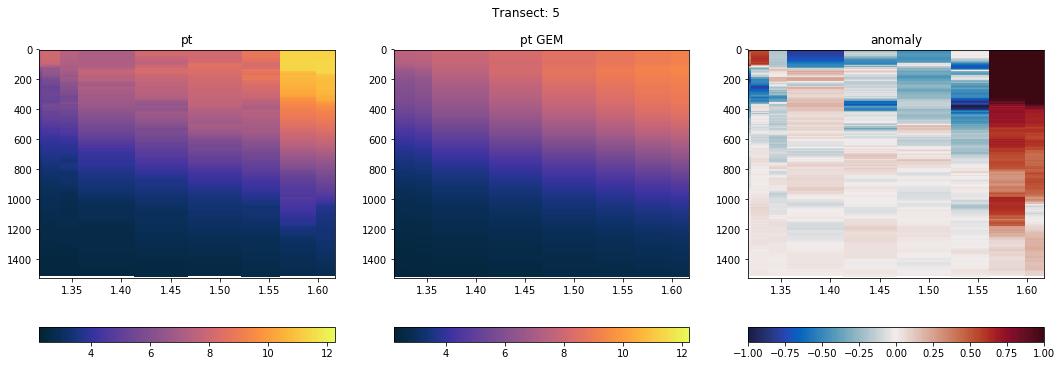

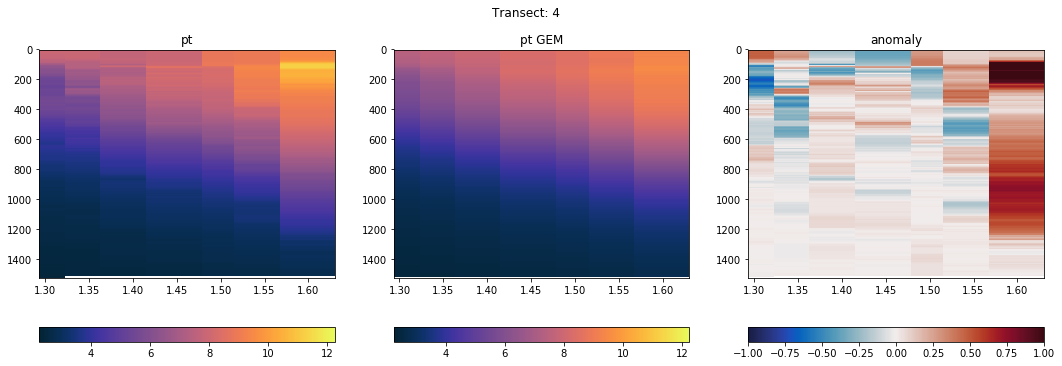

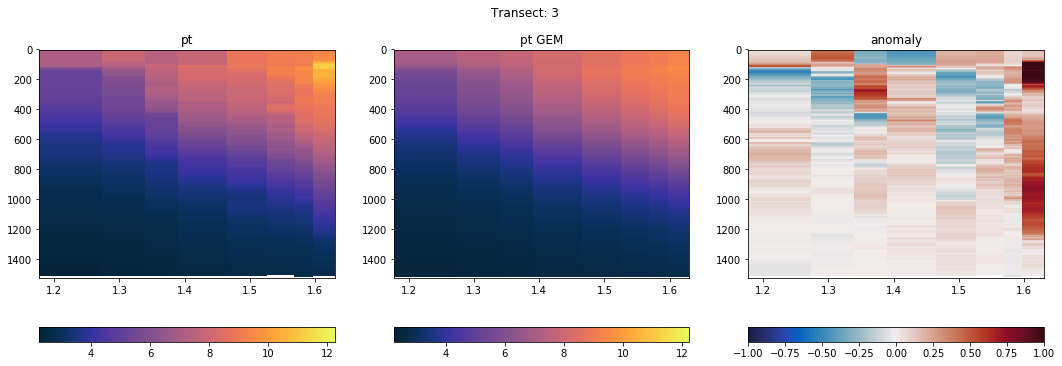

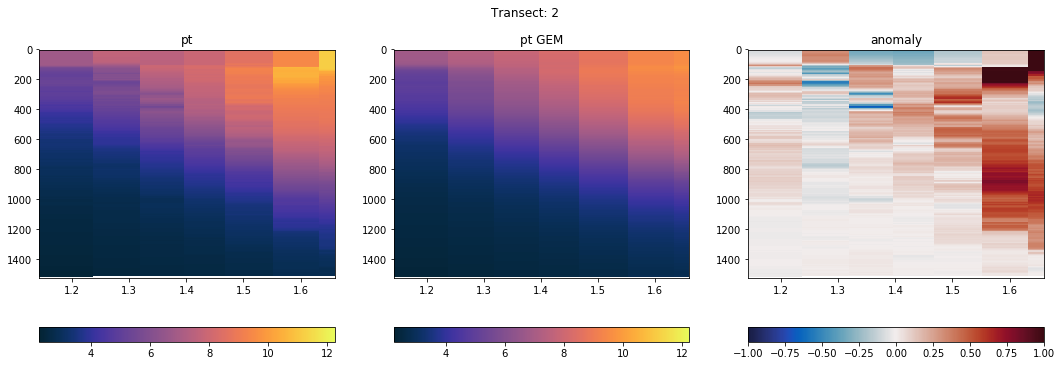

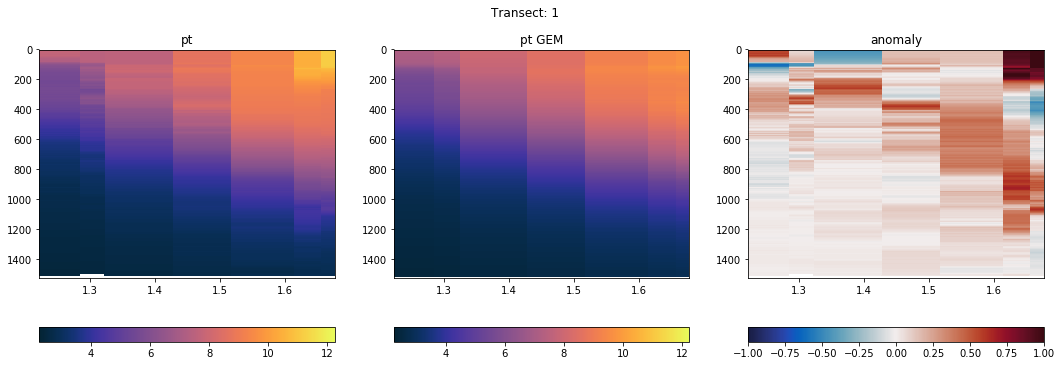

In [4]:
# transect stations
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}

attr = {'pt' : ('Potential Temperature', cmo.cm.thermal, (2.25, 12.25), cmo.cm.balance, (-1, 1, 16)), 
        'CT' : ('Conservative Temperature', cmo.cm.thermal, (2, 12), cmo.cm.balance, (-1, 1, 16)), 
        'SA': ('Absolute Salinity', cmo.cm.haline, (34, 35), cmo.cm.delta, (-0.2, 0.2, 16)),
        'sigma0': ('Potential density', cmo.cm.dense, (26.4, 27.7), cmo.cm.curl, (-0.05, 0.05, 16)),
        'gamman': ('Neutral density', cmo.cm.dense, (26.35, 27.95), cmo.cm.curl, (-0.05, 0.05, 16))
       }

var = 'pt'
anomaly = ctd[var][:] - gem[var][:]

for transect in reversed(list(transects.keys())):
    stations = transects[transect]  
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    pcol = ax[0].pcolor(D[stations], ctd['p'], ctd[var][stations].T, 
                        cmap=attr[var][1], vmin=attr[var][2][0], vmax=attr[var][2][1])
    plt.colorbar(pcol, ax=ax[0], orientation='horizontal')
    
    pcol1 = ax[1].pcolor(D[stations], ctd['p'], gem[var][stations].T, 
                         cmap=attr[var][1], vmin=attr[var][2][0], vmax=attr[var][2][1])
    plt.colorbar(pcol1, ax=ax[1], orientation='horizontal')
    
#     pcol2 = ax[2].pcolor(D[stations], ctd['p'], ctd[var][stations].T - gem[var][stations].T, 
#                         cmap=attr[var][3], vmin=attr[var][4][0], vmax=attr[var][4][1])
    pcol2 = ax[2].pcolor(D[stations], ctd['p'], anomaly[stations].T,
                         cmap=attr[var][3], vmin=attr[var][4][0], vmax=attr[var][4][1])
    plt.colorbar(pcol2, ax=ax[2], orientation='horizontal')
   
    for axis in range(len(ax)):
        ax[axis].set_title({1: var + ' GEM', 2: 'anomaly'}.get(axis, var))
        ax[axis].invert_yaxis()
    fig.suptitle('Transect: %s' % transect)


## Anomaly for each transect (interpolated)

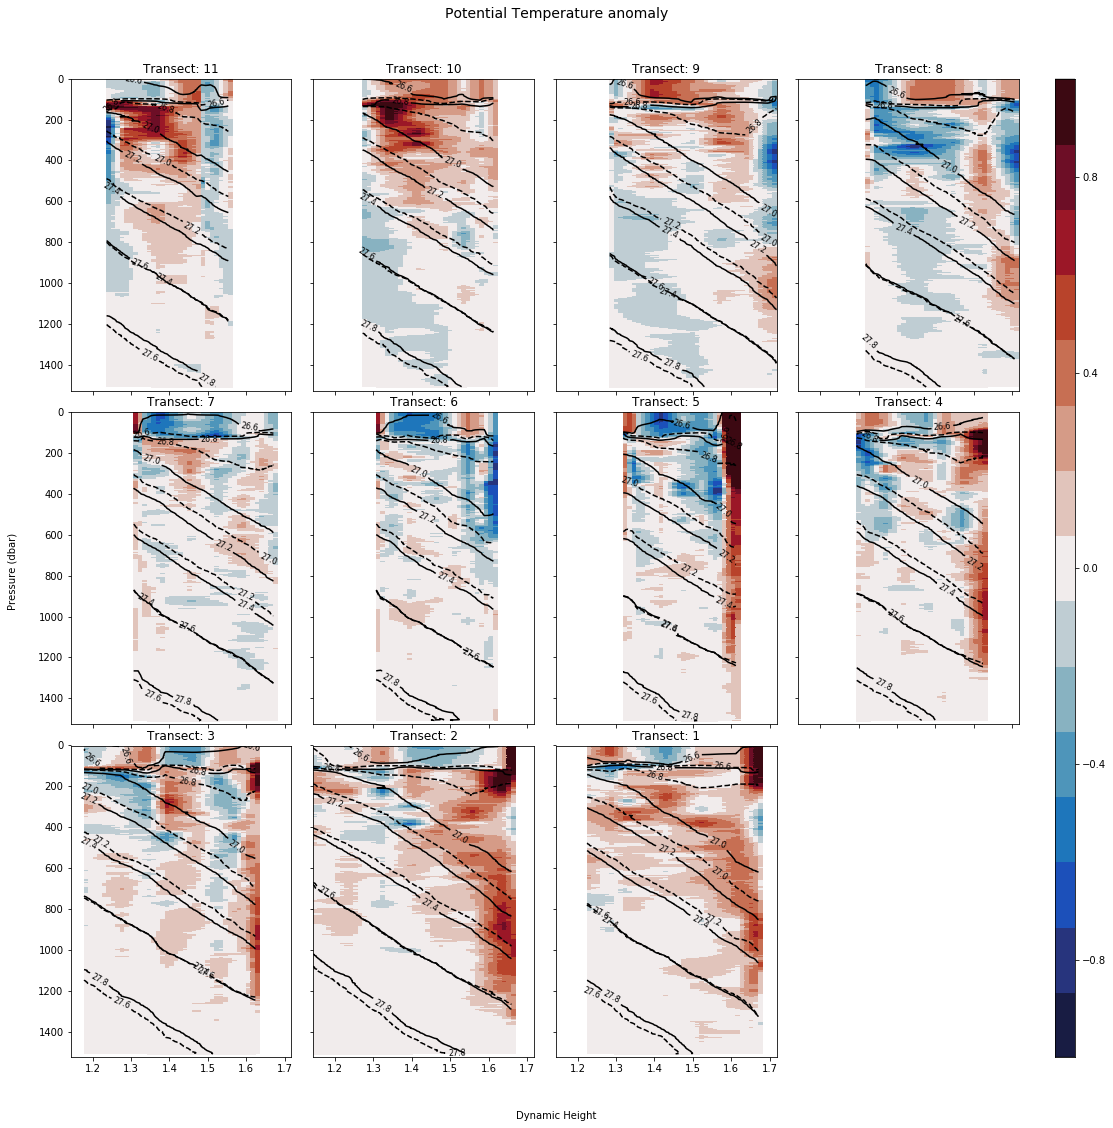

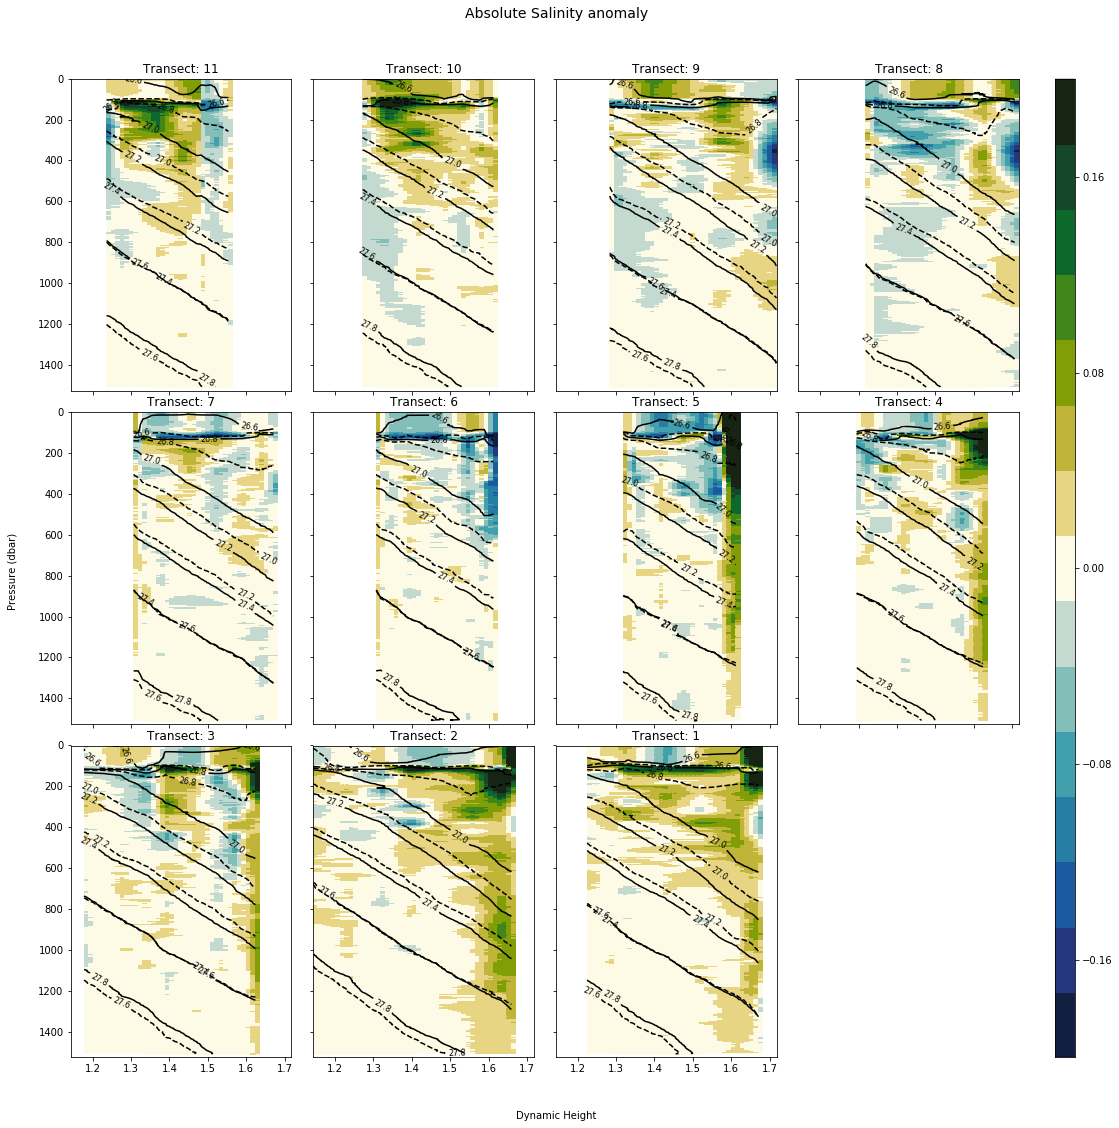

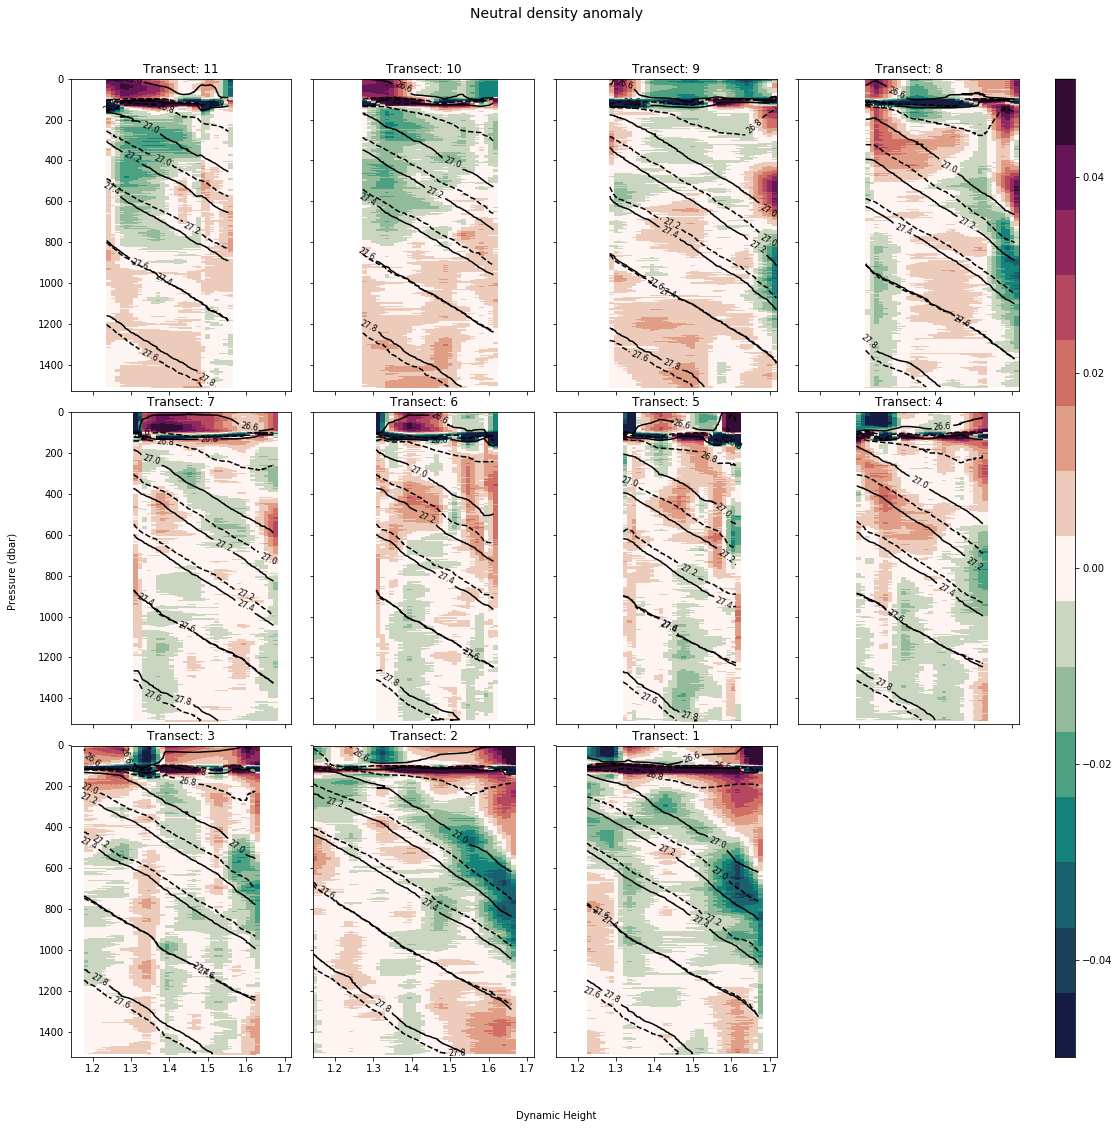

In [5]:
Di = np.linspace(np.nanmin(D), np.nanmax(D))
# DD, pp = np.meshgrid(Di, ctd['p'][:])
Dgrd, pgrd = np.meshgrid(Di, ctd['p'][:])

for var in ['pt', 'SA', 'gamman']:
    
    anomaly = ctd[var][:] - gem[var][:]
    
    bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
    norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)
    # cb = ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=[-1] + bounds + [1], extend='both')

    fig = plt.figure(figsize=(18, 18))
    grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.3, add_all=True, share_all=True, aspect=False,
                     cbar_mode='single', cbar_location='right', cbar_size="3%", cbar_pad=0.5, label_mode="L")

    # grid[0].set_xlabel('Dynamic Height')
    # grid[0].set_ylabel('Pressure (dbar)')

    for ax, transect in zip(grid, reversed(list(transects.keys()))):
        stations = transects[transect]

        mask = ctd['pt'][stations].mask | gem['pt'][stations].mask
        pgrd_ts, Dgrd_ts = np.meshgrid(ctd['p'][:], D[stations])
      
        points = list(zip(Dgrd_ts[~mask].flatten(), pgrd_ts[~mask].flatten()))
        values = anomaly[stations][~mask].flatten()

#         ctd_interp = griddata(points, ctd[var][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')
#         gem_interp = griddata(points, gem[var][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')

        # anomaly
        anomaly_interp = griddata(points, values, (Dgrd, pgrd), method='linear')
#         anomaly_interp = ctd_interp - gem_interp   


        # potential and neutral densty surfaces
        sigma0grd = griddata(points, ctd['sigma0'][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')
        gammangrd = griddata(points, ctd['gamman'][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')


        pcol = ax.pcolormesh(Dgrd, pgrd, anomaly_interp, norm=norm, cmap=attr[var][3])

        cont = ax.contour(Dgrd, pgrd, gammangrd, colors='k')
        cont2 = ax.contour(Dgrd, pgrd, sigma0grd, colors='k', linestyles='--')
#         cont2 = ax.contour(D[stations], ctd['p'][:], ctd['sigma0'][stations,].T, colors='k', linestyles='--')
        if transect % 2:
            ax.invert_yaxis()
            ax.clabel(cont, inline=1, fontsize=8, fmt='%.1f', inline_spacing=40)
            ax.clabel(cont2, inline=1, fontsize=8, fmt='%.1f', inline_spacing=40)
        else:
            ax.clabel(cont, inline=1, fontsize=8, fmt='%.1f', inline_spacing=40)
            ax.invert_yaxis()

        ax.set_title('Transect: %s' % transect)

    ax.cax.colorbar(pcol)
    # ax.cax.colorbar(pcol, extend='both')
#     ax.cax.toggle_label(True)

    fig.delaxes(grid[-1])
    # fig.suptitle(titles[var] + ' anomaly')

    # Set common labels
    fig.text(0.5, 0.93, attr[var][0] + ' anomaly', ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.08, 'Dynamic Height', ha='center', va='center')
    fig.text(0.08, 0.5, 'Pressure (dbar)', ha='center', va='center', rotation='vertical')

## Taylor series of anomaly on pressure and neutral density surfaces

The potential temperature anomaly on pressure levels between the measurements and the GEM field can be expressed in a Taylor series of the anomaly on neutral density levels. In this way, a heaving of the water masses can be identified.

$$\theta'\left.\right\rvert_{p} = \theta'\left.\right\rvert_{\gamma_n} + \textrm{d}z_{\gamma_n} \left(\frac{\partial\theta}{\partial z}\right)_p$$

$$\theta'\left.\right\rvert_{p} = \theta'\left.\right\rvert_{\gamma_n} + (z_p - z_{\gamma_n}) \left.\frac{\partial\theta'}{\partial z}\right\rvert_{\gamma_n}$$


where,

$$\theta'\left.\right\rvert_{p} = \left(\theta - \theta_{ref, GEM}\right)_p$$

Text(0.08, 0.5, 'Neutral density')

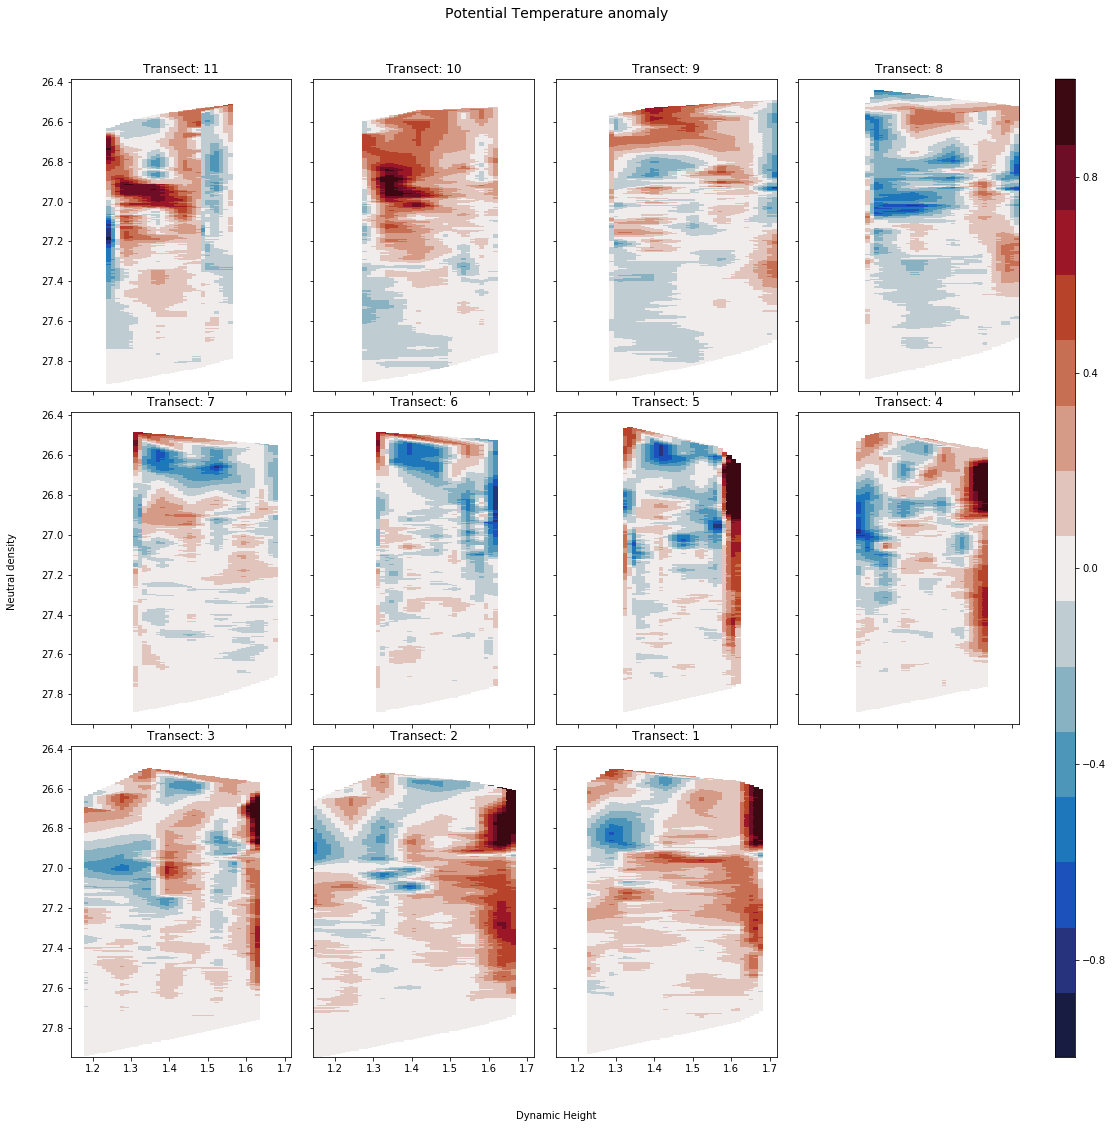

In [6]:
# interpolate
gamman = np.ma.masked_invalid(ctd['gamman'])
gammani = np.linspace(gamman.min(), gamman.max(), ctd['p'].size)
gammangrd = np.broadcast_to(gammani, Dgrd.T.shape).T 

var = 'pt'
anomaly = ctd[var][:] - gem[var][:]

bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig = plt.figure(figsize=(18, 18))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.3, add_all=True, share_all=True, aspect=False,
                 cbar_mode='single', cbar_location='right', cbar_size="3%", cbar_pad=0.5, label_mode="L")

for ax, transect in zip(grid, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    mask = ctd[var][stations].mask | gem[var][stations].mask
    
    Dgrd_ts = np.broadcast_to(D[stations], gamman[stations].T.shape).T
    gammangrd_ts = gamman[stations]

    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = anomaly[stations][~mask].flatten()

    anomaly_interp = griddata(points, values, (Dgrd, gammangrd), method='linear')

    pcol = ax.pcolormesh(Dgrd, gammangrd, anomaly_interp, norm=norm, cmap=attr[var][3])

    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

ax.cax.colorbar(pcol)
# ax.cax.colorbar(pcol, extend='both')
ax.cax.toggle_label(True)

fig.delaxes(grid[-1])
# fig.suptitle(titles[var] + ' anomaly')

# Set common labels
fig.text(0.5, 0.93, attr[var][0] + ' anomaly', ha='center', va='center', fontsize=14)
fig.text(0.5, 0.08, 'Dynamic Height', ha='center', va='center')
fig.text(0.08, 0.5, 'Neutral density', ha='center', va='center', rotation='vertical')



In [7]:
from OceanPy.stability import layer_depth

gamman_coord, z_gamman = layer_depth(ctd['gamman'], ctd['z'])
_, z_gamman_gem = layer_depth(gem['gamman'], ctd['z'])

dz = z_gamman - z_gamman_gem


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


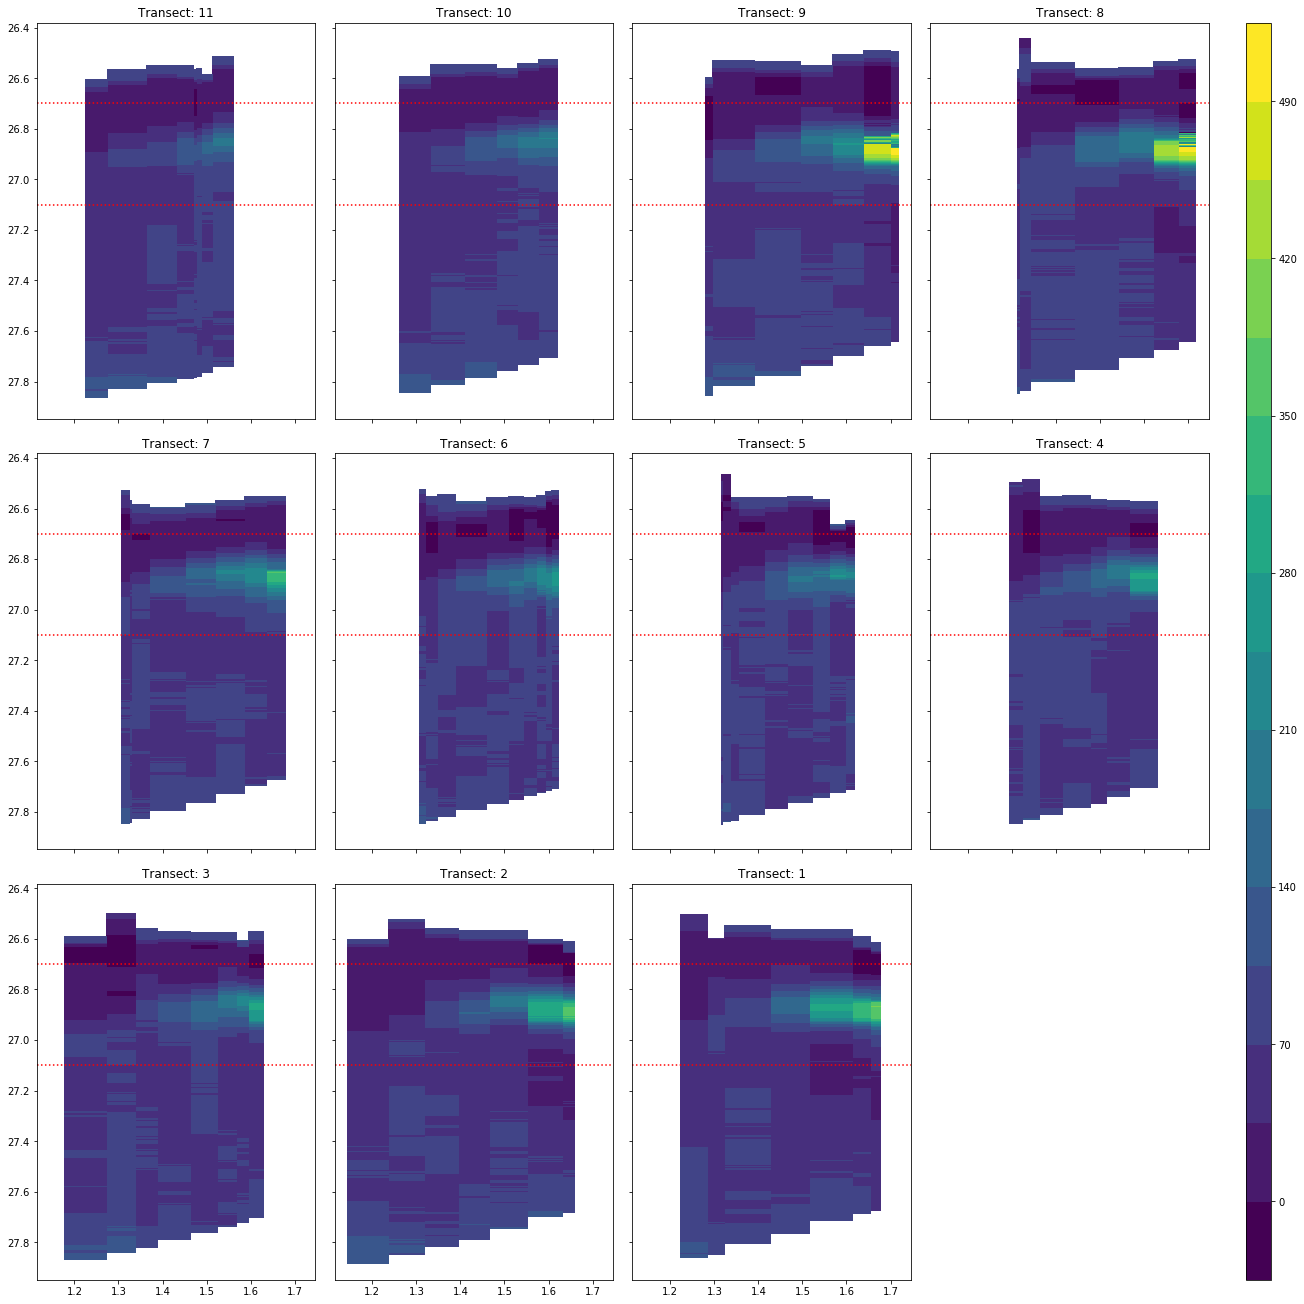

In [58]:

#### https://joseph-long.com/writing/colorbars/
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

gamman_int_upper = 26.7 # 27.4 #
gamman_int_lower = 27.1 # 27.6 #
cmap = plt.cm.viridis
bounds = np.linspace(-35, 525, 17)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]

    pcol = ax.pcolormesh(D[stations], gamman_coord, dz[stations].T, norm=norm, cmap=cmap)
    ax.axhline(y=gamman_int_upper, color='r', linestyle=':')
    ax.axhline(y=gamman_int_lower, color='r', linestyle=':')
    ax.invert_yaxis()
    ax.set_title('Transect: %s' % transect)

fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])


In [59]:
anomaly = ctd['pt'][:] - gem['pt'][:]
dthetadz = np.gradient(anomaly)[1] / np.gradient(ctd['z'][:])[1]

# print(np.nanmin(dz*dthetadz), np.nanmax(dz*dthetadz))
# anomaly.shape

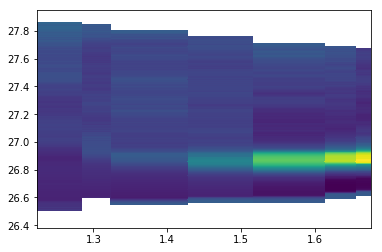

In [60]:
plt.pcolormesh(D[stations], gamman_coord, dz[stations].T)


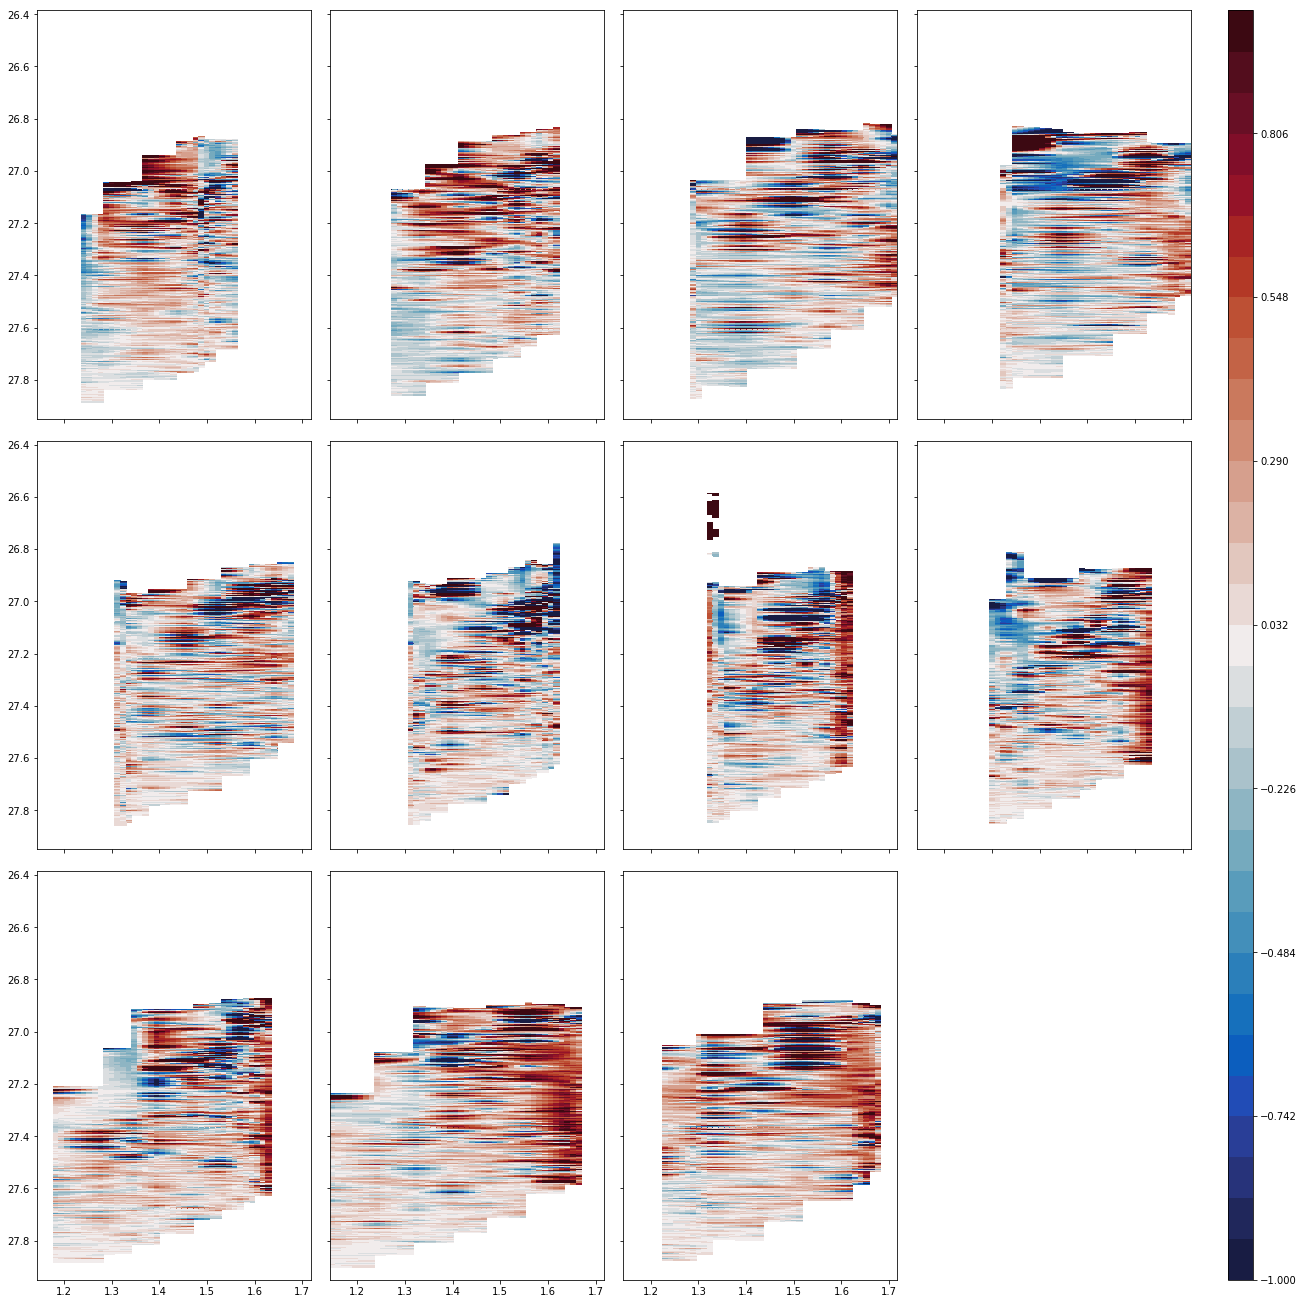

In [61]:
cmap = cmo.cm.balance
bounds = np.linspace(-1, 1, 32)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
for ax, transect in zip(axes.flat, reversed(list(transects.keys()))):
    stations = transects[transect]
    
    mask = dthetadz[stations].mask#ctd[var][stations].mask | gem[var][stations].mask

    Dgrd_ts = np.broadcast_to(D[stations], gamman[stations].T.shape).T
    gammangrd_ts = gamman[stations]
    
    points = list(zip(Dgrd_ts[~mask].flatten(), gammangrd_ts[~mask].flatten()))
    values = (anomaly[stations] + dz[stations] * dthetadz[stations])[~mask].flatten()

    first_order = griddata(points, values, (Dgrd, gammangrd), method='linear')
    
    pcol = ax.pcolormesh(Dgrd, gammangrd, first_order, norm=norm, cmap=cmap)

    ax.invert_yaxis()
fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
fig.delaxes(axes.flat[-1])


In [62]:
from scipy.interpolate import interp1d

anomaly = ctd['pt'][:] - gem['pt'][:]
anomaly_int = []
for ist in range(ctd.dimensions['profile'].size):
    idx_u = (np.abs(gamman[ist] - gamman_int_upper)).argmin()
    idx_l = (np.abs(gamman[ist] - gamman_int_lower)).argmin()
    anomaly_int.append(np.mean(anomaly[ist, idx_u:idx_l]))
anomaly_int = np.array(anomaly_int)


anomaly_hor = np.ma.masked_all((len(transects.keys()),) + Di.shape)
for its, transect in enumerate(transects.keys()):
    stations = transects[transect]
    
    f = interp1d(D[stations], anomaly_int[stations], bounds_error=False)
    anomaly_hor[its,:] = f(Di)
    

# try scatter plot below, to get 11 transects and not 10 pcolor strokes

Text(0, 0.5, 'Dynamic Height')

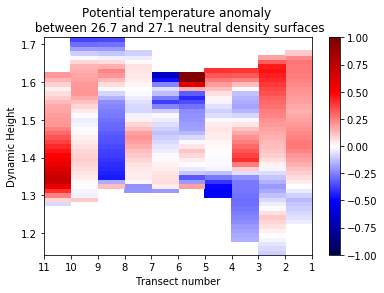

In [66]:
fig, ax = plt.subplots()
pcol = ax.pcolor(np.arange(1, len(transects.keys()) + 1) , Di, anomaly_hor.T, cmap=plt.cm.seismic, vmin=-1, vmax=1)
ax.invert_xaxis()
ax.set_xticks(np.arange(1, len(transects.keys()) + 1))
plt.colorbar(pcol)

plt.title('Potential temperature anomaly \n between %s and %s neutral density surfaces' % (gamman_int_upper, gamman_int_lower))
plt.xlabel('Transect number')
plt.ylabel('Dynamic Height')

In [79]:
tsi

array([11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])